# ArcticHeat Alamo Deployments:

Template for analysis of any desired instrument.

Read in the data that is hosted by ERDDAP (PMEL)
Visualize the data as a timeseries.
Visualize the data as a geolocation plot

__pyversion__==3.7   
__author__==S.Bell

In [19]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-04-29 09:52:42.411539


## Connecting to the ERDDAP Server and retrieving basic information / building the data call.

as always, python package imports to start the program
- importing erddap, pandas and numpy for data aquisition, data manipulation and math manipulation
- data visualization via matplotlib has imports later (including cmocean) just for clarity in work flow but usually all imports are at the top of the program

http://ferret.pmel.noaa.gov/alamo/erddap is the erddap server run by PMEL with the ALAMO floats associated with the https://www.pmel.noaa.gov/arctic-heat/ program

This section could be skipped if data was downloaded directly to your system from an ERDDAP url page manually - just read that data straight in to pandas and jump to the next section.

In [20]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://ferret.pmel.noaa.gov/alamo/erddap'
e = ERDDAP(server=server_url)

Get only ALAMO Float datafiles - can be found by searching for arctic.

Searching on ALAMO provides an "alldata" response that would need to be filtered out

Searching on the float serial gives us just the dataset we want (well and another because the search terms don't give us a unique result in this case)

In [21]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='arctic and 9234'))

In [22]:
alamos = df['Dataset ID'].values
print(alamos)


['arctic_heat_alamo_profiles_9234' 'arctic_heat_alamo_profiles_9153']


In [23]:
#isolate just the data set we want
alamos = ['arctic_heat_alamo_profiles_9234']

In [24]:
#establish data constraints - not necessary but will help subselect a data stream if the resultant data is large
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2020-03-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [25]:
#get variables based on standard name attribute - useful as this is a piece of standardized metadata
#this line is more useful if you are combining multiple data sets (multiple floats or two distinct data streams)
variables = [e.get_var_by_attr(dataset_id=alamo, standard_name=lambda v: v is not None) for alamo in alamos]
print(variables)

[['TEMP', 'latitude', 'longitude', 'time', 'PSAL', 'PRES', 'JULD_LOCATION']]


In [26]:
#choose the variables common to both data sets - not needed for only one dataset but still useful
common_variables = set(variables[0]).intersection(*variables[1:])

#add back variables without standard names that you know are useful and in the dataset
common_variables.update(['CYCLE_NUMBER']) 
print(common_variables)

{'time', 'TEMP', 'PSAL', 'CYCLE_NUMBER', 'PRES', 'JULD_LOCATION', 'latitude', 'longitude'}


In [27]:
#set constraints established earlier
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

#build download url
download_url = e.get_download_url(
    dataset_id=alamos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
)

#the following url is a functional link, but we will pass it to pandas to get the data.  Clicking below will provide guidance should your
# data call construction above have an error in it
print(download_url)

http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_9234.csv?time,TEMP,PSAL,CYCLE_NUMBER,PRES,JULD_LOCATION,latitude,longitude


## Retrieving erddap data

In [28]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints #<-- remove or comment this line to also get data without valid lat/lons for ALAMO dataset
        e.variables=common_variables 
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True
                            )})
    except:
        print('Failed to ingest {}'.format(alamo))


arctic_heat_alamo_profiles_9234


you should now have a dictionary of data for each float (only one entry for this example).

Also note, because there are some data points without valid lat/lon parameters, that data is constrained out of the data call.  If you want that data back, you must remove the lat/lon contraints (this is a small dataset so you could remove the constraints line all together)

### and plotting data

In [29]:
# call matplotlib routines
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale


In [30]:
### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

## Depth v Time/Dive Profiles

erddap -> pandas ingest earlier already indexes data by time, plot variables of interest against this index will give you time/data plots.  These are waterfall plots below, any form of contouring is a bit more challenging but by either gridding or using pcolormesh, various plots can be explored

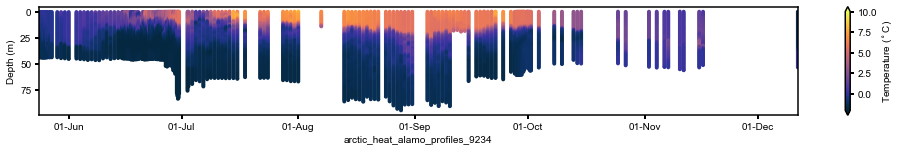

In [31]:
#for loop is to loop through multiple alamo floats, we only have one so this will only create one plot
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES (decibar)'], s=15, c=df['TEMP (degree_Celsius)'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)
    
    #fig.savefig(dfn+'.png',dpi=300)

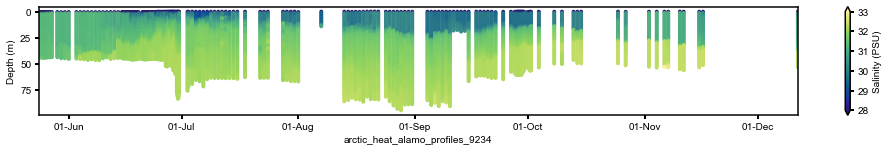

In [32]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES (decibar)'], s=15, c=df['PSAL (PSU)'], marker='o', edgecolor='none', vmin=28, vmax=33,cmap=cmocean.cm.haline)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

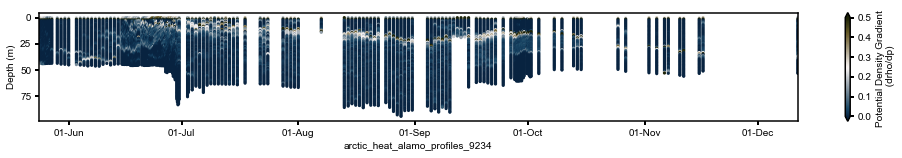

In [33]:
import seawater #<-- for conversion to pot dens using TEOS equations
for dfn, df in dfs.items():
    df['potdens'] = seawater.pden(s=df['PSAL (PSU)'],t=df['TEMP (degree_Celsius)'],p=df['PRES (decibar)'])
    
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES (decibar)'], s=10, c=df['potdens'].diff()/df['PRES (decibar)'].diff(), marker='o',
                    vmin=0, vmax=0.5, edgecolor='none',cmap=cmocean.cm.diff)

    ax.invert_yaxis()
    ax.set_xlim(df.index.min(), df.index.max())
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Potential Density Gradient \n (drho/dp)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)